# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

Instrument(1 array)
├ arrays:
│             n           FOV baseline        bands
│  array1  1356  5.953 arcmin      0 m  [f090,f150]
│ 
└ bands:
          center   width    η         NEP   NET_RJ     NET_CMB          FWHM
   f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  8.748 arcsec
   f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s  5.249 arcsec


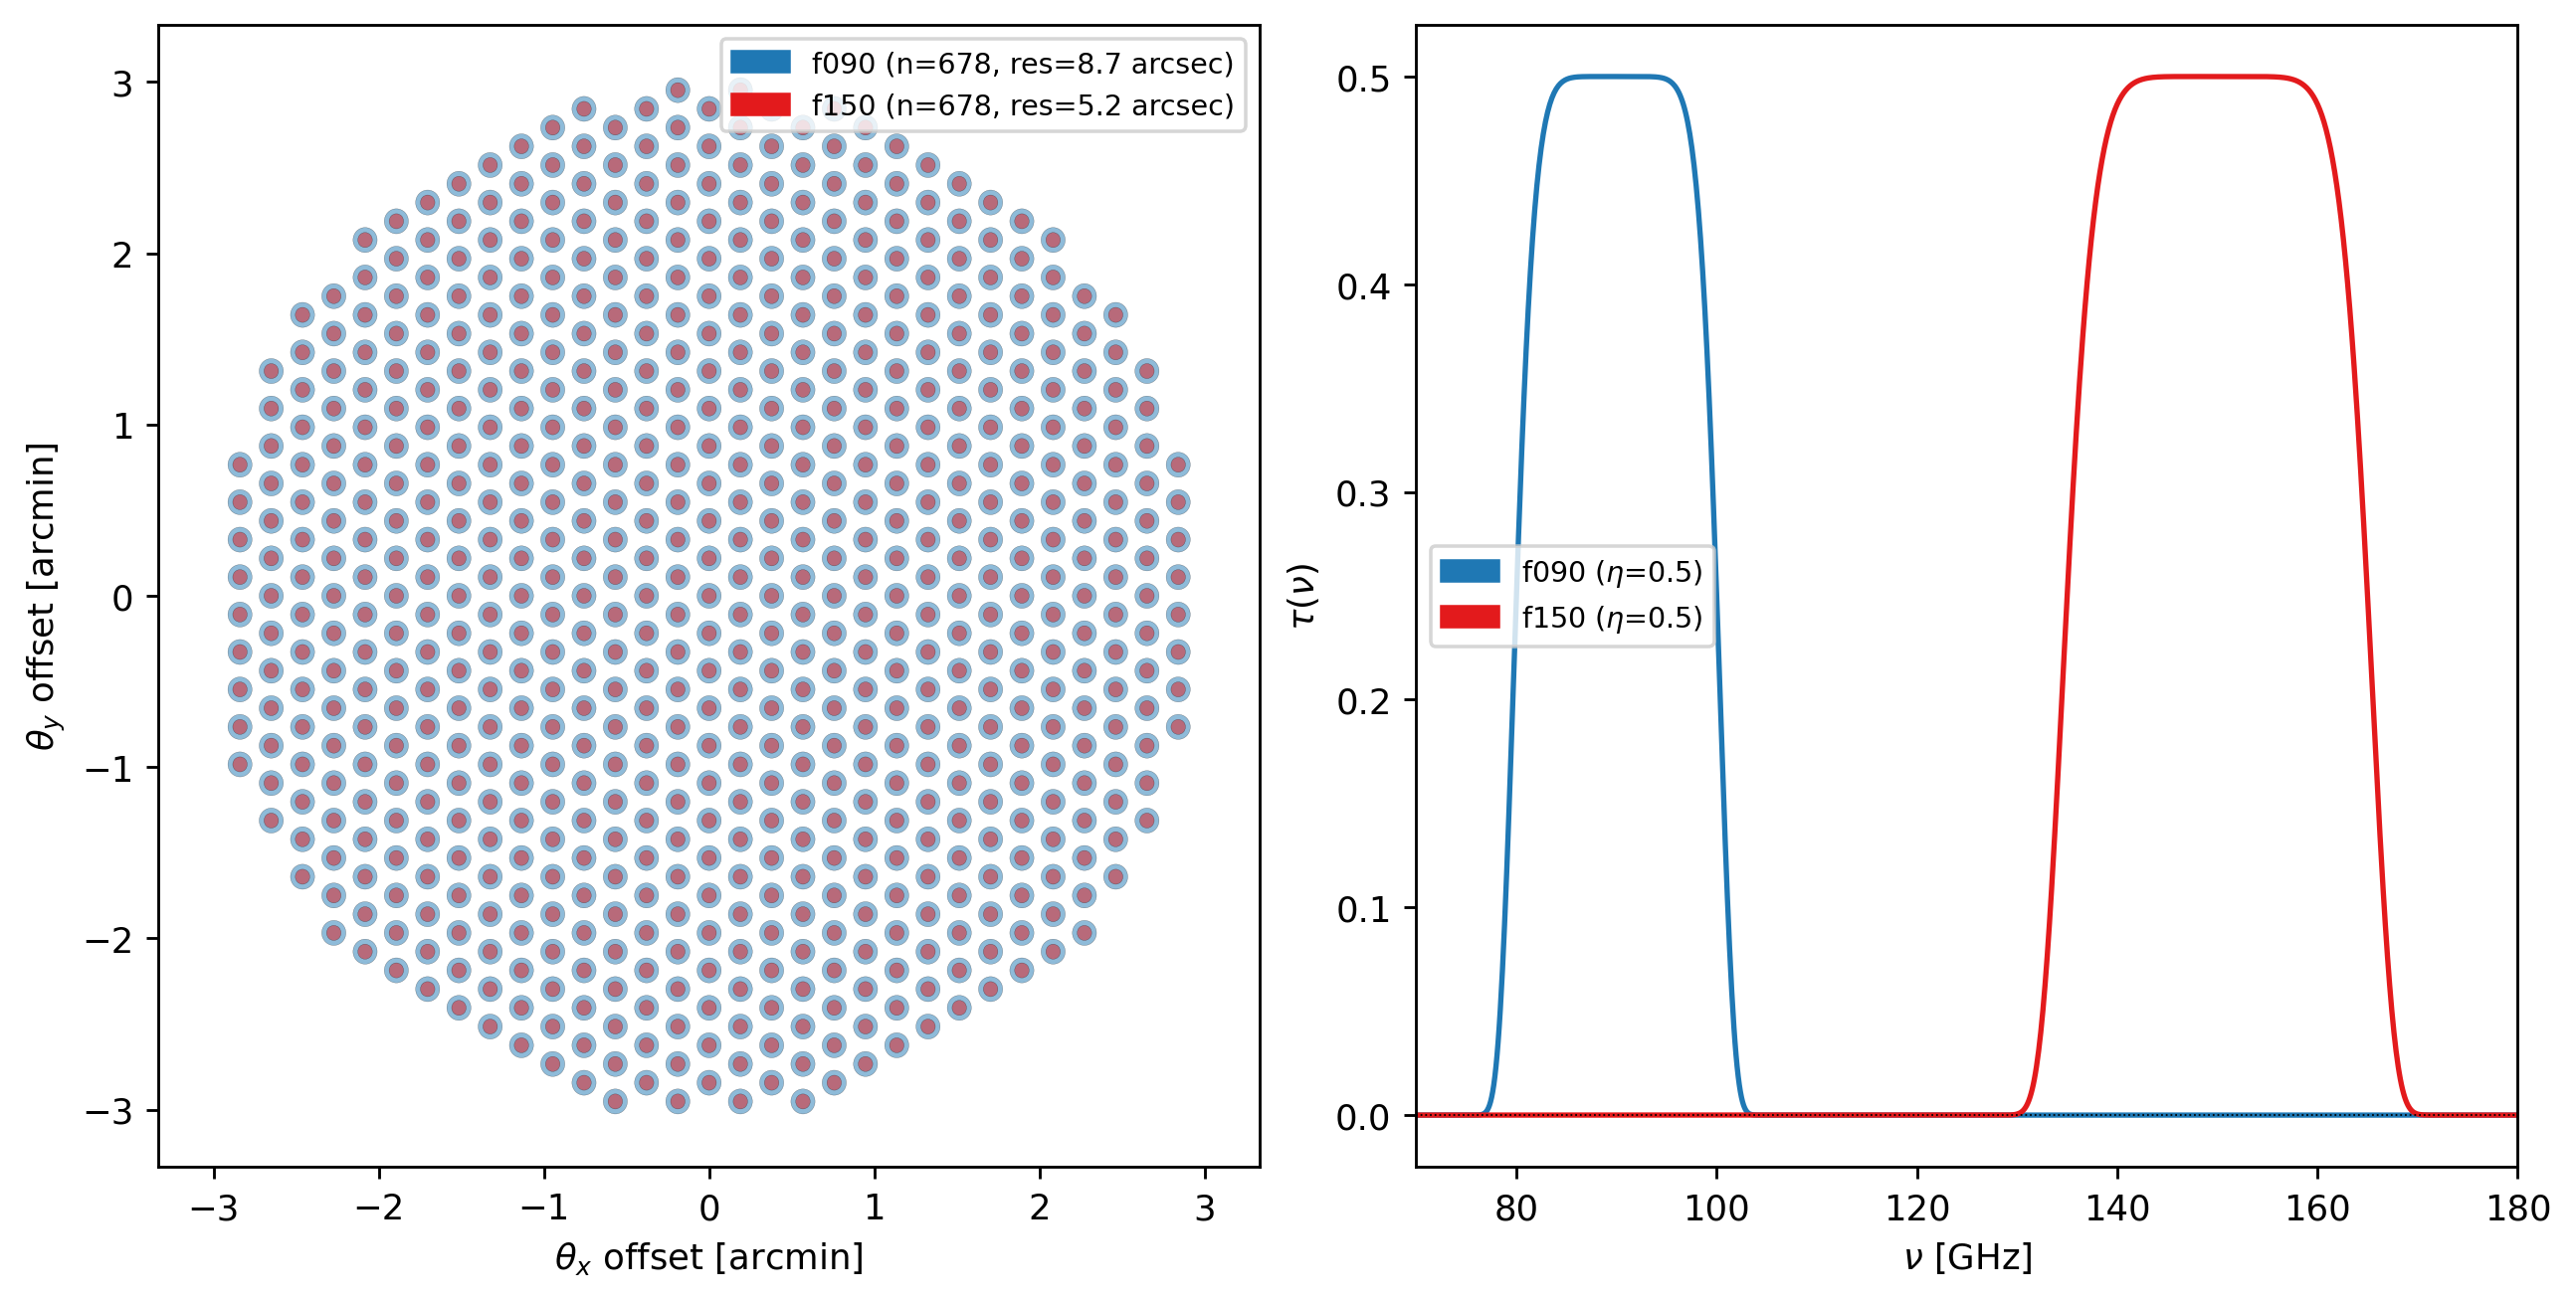

In [2]:
array = {"field_of_view": 0.1, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 100, 
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument)
instrument.plot()

As something to observe, we can download a map and construct a `map`. We also define a plan to do a daisy scan centered on the center of the map.

ProjectedMap:
  shape[stokes, nu, t, y, x]: (1, 1, 1, 251, 251)
  stokes: ['I']
  nu: [150.] GHz
  t: [1.74370329e+09] s
  quantity: spectral_flux_density_per_pixel
  units: uJy/pixel
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  size[y, x]: (15 arcmin, 15 arcmin)
  resolution[y, x]: (3.586 arcsec, 3.586 arcsec)


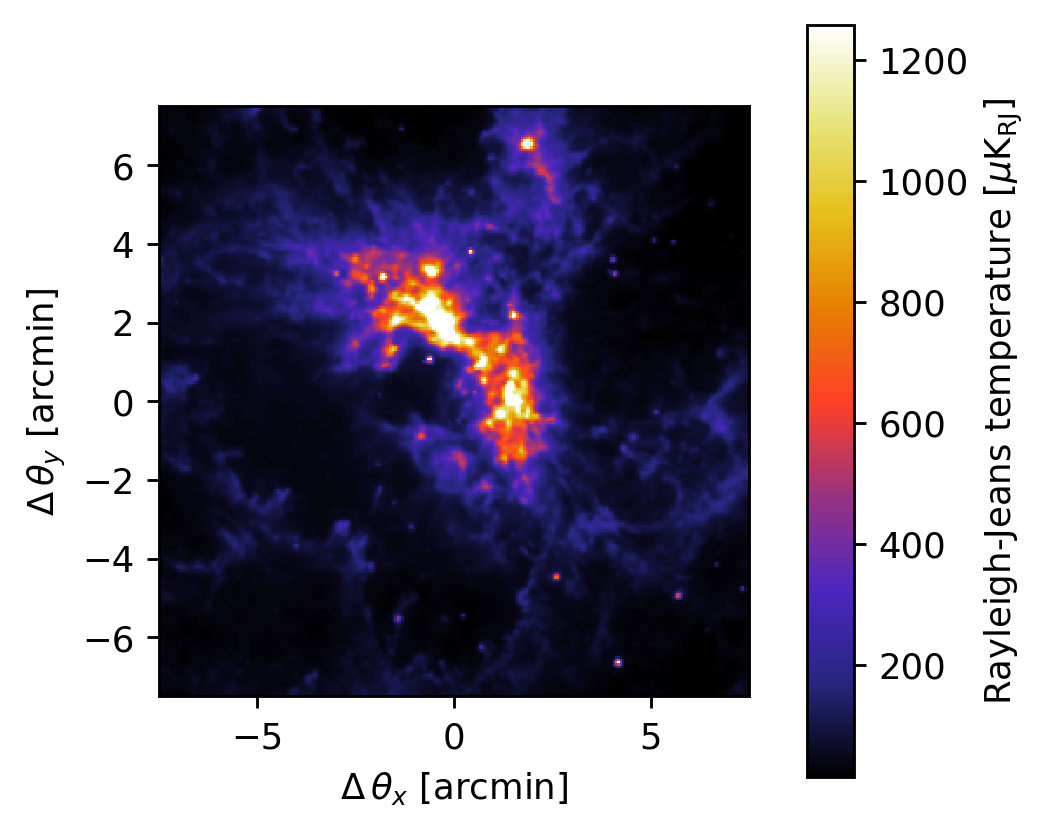

In [3]:
from maria.io import fetch

map_filename = fetch("maps/tarantula_nebula.h5")

input_map = maria.map.load(
    filename=map_filename,
    nu=150e9,
    width=0.25,
    center=(291.156, -31.23),
    units="uJy/pixel")

print(input_map)
input_map.to("K_RJ").plot()

Site:
  region: chajnantor
  location: 23°01’45.84”S 67°45’17.28”W
  altitude: 5.065 km
  seasonal: True
  diurnal: True


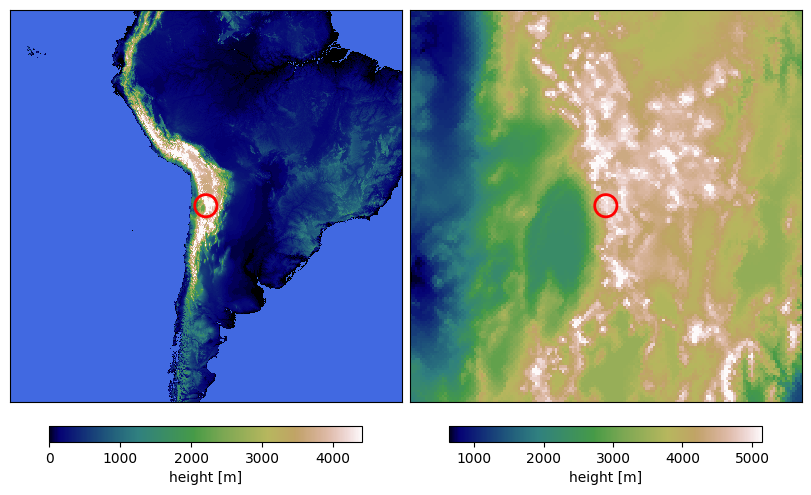

In [4]:
site = maria.get_site("llano_de_chajnantor", altitude=5065)

print(site)
site.plot()

Plan:
  start_time: 2024-08-06 03:00:00.000 +00:00
  duration: 1200 s
  sample_rate: 50 Hz
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  scan_pattern: daisy
  scan_kwargs: {'radius': 0.08, 'speed': 0.01}


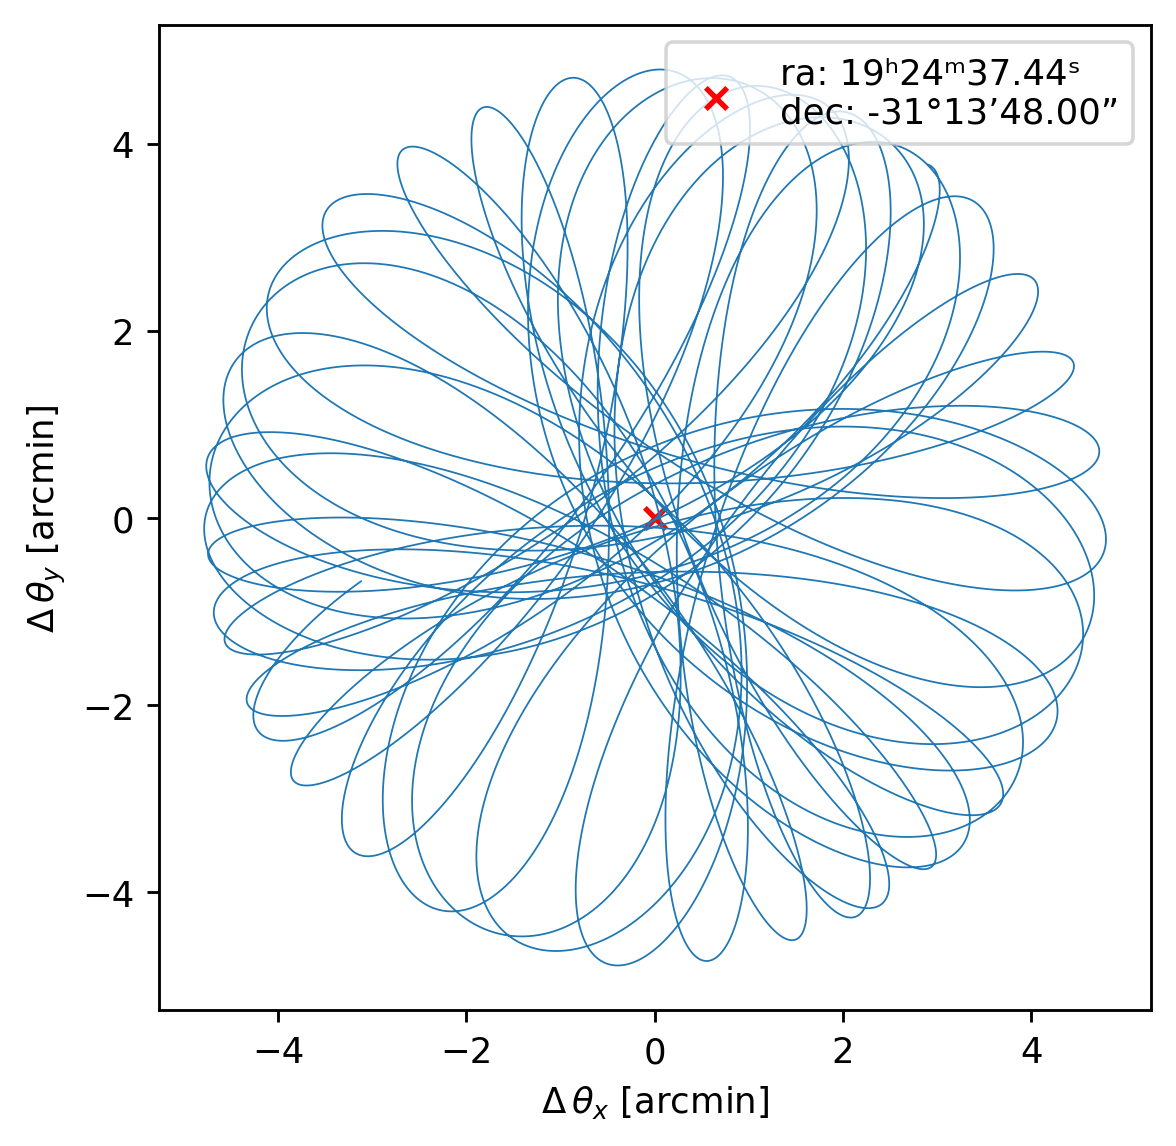

In [5]:
plan = maria.Plan(
    start_time="2024-08-06T03:00:00",
    scan_pattern="daisy",
    scan_options={"radius": 0.08, "speed": 0.01},  # in degrees
    duration=1200,  # in seconds
    sample_rate=50,  # in Hz
    scan_center=(291.156, -31.23),
    frame="ra_dec")

print(plan)
plan.plot()

In [6]:
sim = maria.Simulation(
    instrument,
    plan=plan,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map)

print(sim)

Constructing atmosphere:   0%|          | 0/6 [00:00<?, ?it/s]

Constructing atmosphere:  17%|█▋        | 1/6 [00:03<00:17,  3.45s/it]

Constructing atmosphere:  33%|███▎      | 2/6 [00:06<00:13,  3.37s/it]

Constructing atmosphere:  50%|█████     | 3/6 [00:10<00:09,  3.32s/it]

Constructing atmosphere:  67%|██████▋   | 4/6 [00:13<00:06,  3.35s/it]

Constructing atmosphere:  83%|████████▎ | 5/6 [00:16<00:03,  3.31s/it]

Constructing atmosphere: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]

Constructing atmosphere: 100%|██████████| 6/6 [00:19<00:00,  3.33s/it]

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │             n           FOV baseline        bands
│ │  array1  1356  5.953 arcmin      0 m  [f090,f150]
│ │ 
│ └ bands:
│           center   width    η         NEP   NET_RJ     NET_CMB          FWHM
│    f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK√s  49.13 uK√s  8.748 arcsec
│    f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK√s    104 uK√s  5.249 arcsec
├ Site:
│   region: chajnantor
│   location: 23°01’45.84”S 67°45’17.28”W
│   altitude: 5.064 km
│   seasonal: True
│   diurnal: True
├ Plan:
│   start_time: 2024-08-06 03:00:00.000 +00:00
│   duration: 1200 s
│   sample_rate: 50 Hz
│   center:
│     ra: 19ʰ24ᵐ37.44ˢ
│     dec: -31°13’48.00”
│   scan_pattern: daisy
│   scan_kwargs: {'radius': 0.08, 'speed': 0.01}
├ Atmosphere(6 processes with 6 layers):
│ ├ spectrum:
│ │   region: chajnantor
│ └ weather:
│     region: chajnantor
│     altitude: 5.064 km
│     time: Aug 5 23:09:59 -04:00
│     pwv[mean, rms]: (0.5 mm, 15 um)
└ ProjectedMap

Generating turbulence:   0%|          | 0/6 [00:00<?, ?it/s]

Generating turbulence:  67%|██████▋   | 4/6 [00:00<00:00, 33.83it/s]

Generating turbulence: 100%|██████████| 6/6 [00:00<00:00, 28.73it/s]

Sampling turbulence:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling turbulence:  17%|█▋        | 1/6 [00:01<00:07,  1.53s/it]

Sampling turbulence:  33%|███▎      | 2/6 [00:03<00:06,  1.53s/it]

Sampling turbulence:  50%|█████     | 3/6 [00:04<00:04,  1.54s/it]

Sampling turbulence:  67%|██████▋   | 4/6 [00:06<00:03,  1.54s/it]

Sampling turbulence:  83%|████████▎ | 5/6 [00:07<00:01,  1.54s/it]

Sampling turbulence: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]

Sampling turbulence: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:07<00:07,  7.43s/it, band=f090]

Computing atmospheric emission:  50%|█████     | 1/2 [00:07<00:07,  7.43s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:14<00:00,  7.11s/it, band=f150]

Computing atmospheric emission: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it, band=f150]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling map:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Sampling map:  50%|█████     | 1/2 [00:12<00:12, 12.05s/it, band=f090]

Sampling map:  50%|█████     | 1/2 [00:12<00:12, 12.05s/it, band=f150]

Sampling map: 100%|██████████| 2/2 [00:22<00:00, 11.34s/it, band=f150]

Sampling map: 100%|██████████| 2/2 [00:22<00:00, 11.45s/it, band=f150]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|          | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|█████     | 1/2 [00:02<00:02,  2.97s/it, band=f090]

Generating noise:  50%|█████     | 1/2 [00:02<00:02,  2.97s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it, band=f150]

Generating noise: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it, band=f150]

TOD(shape=(1356, 60000), fields=['atmosphere', 'map', 'noise'], units='pW', start=2024-08-06 03:19:59.978 +00:00, duration=1200.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-04-04T04:57:23.327828+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 272.519})


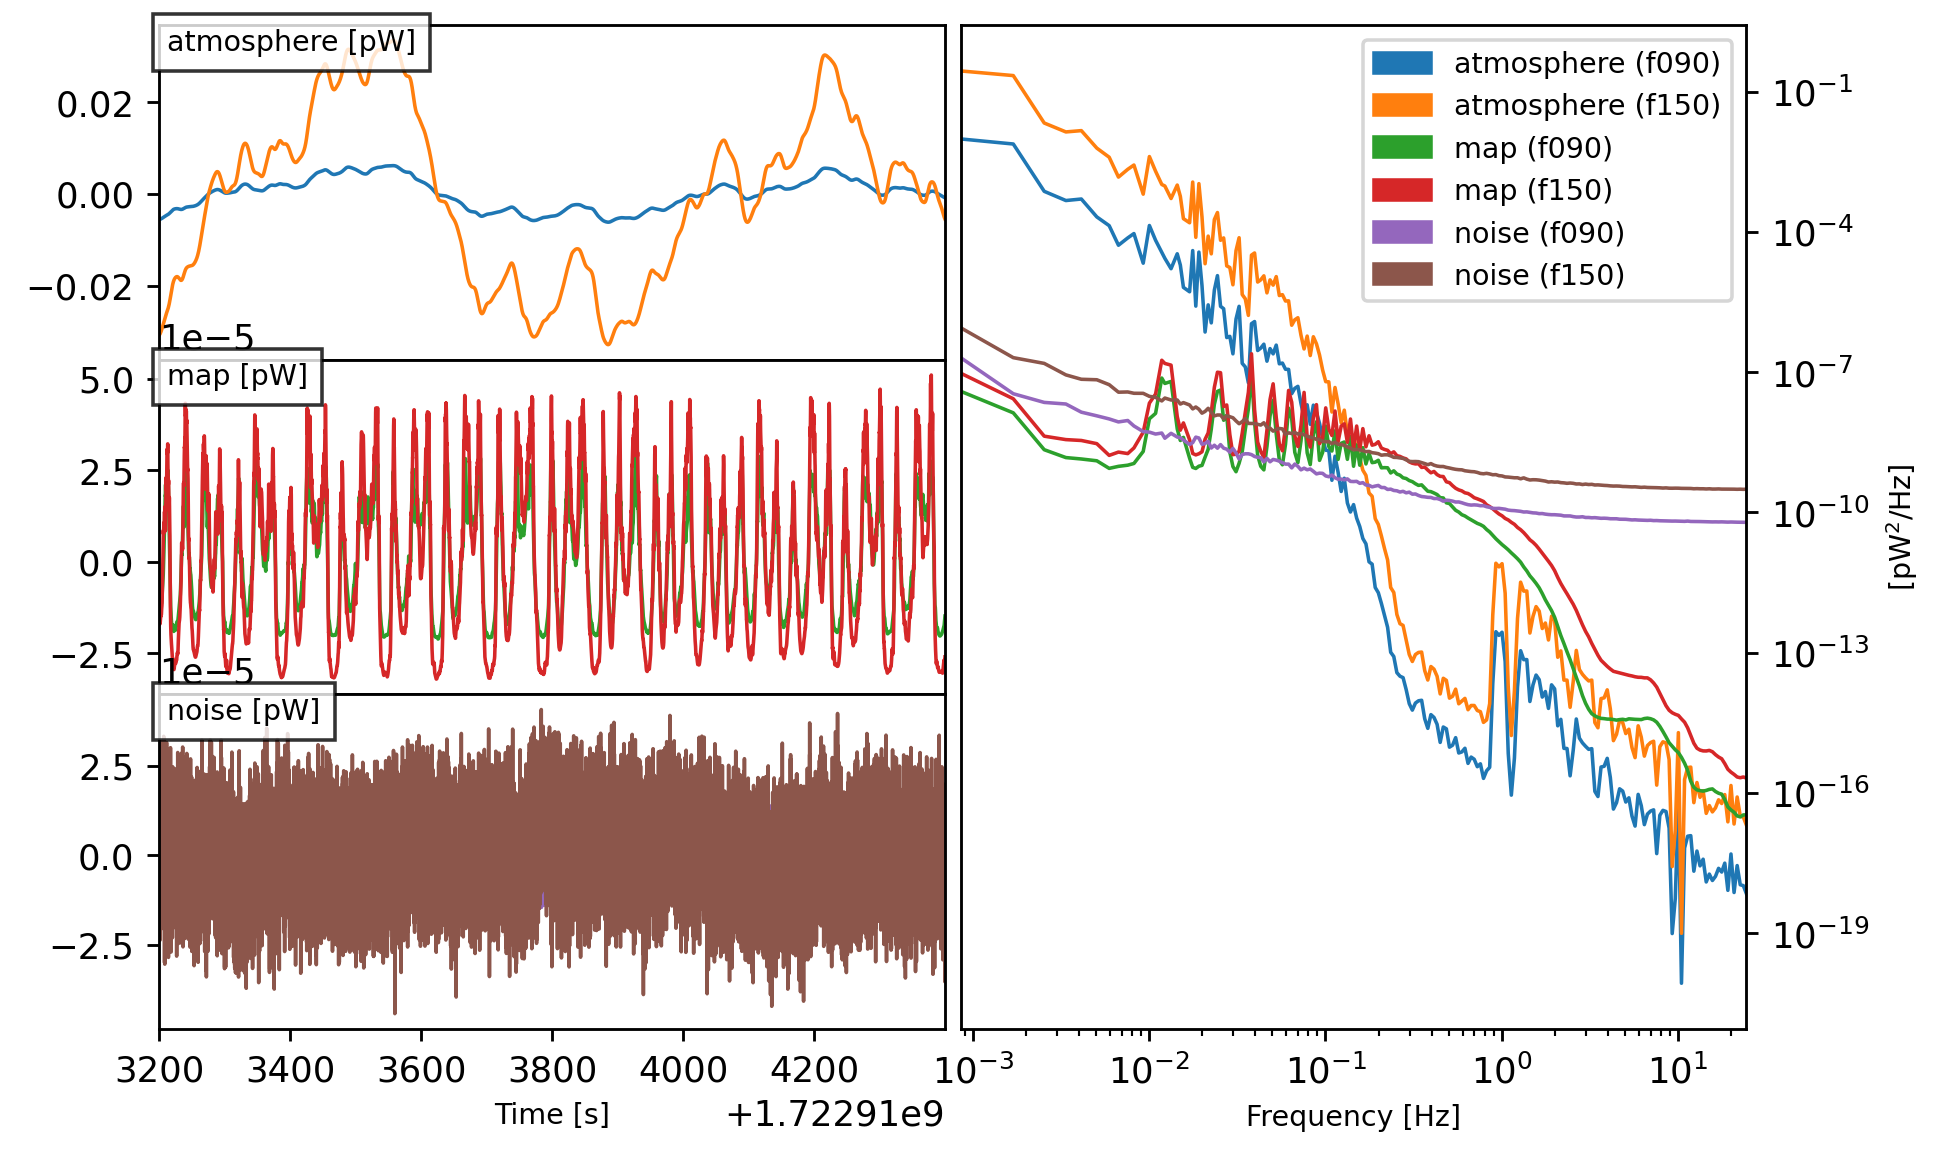

In [7]:
tod = sim.run()

print(tod)
tod.plot()

2025-04-04 04:58:20.066 INFO: Ran mapper for band f090 in 39.56 s.


2025-04-04 04:58:59.376 INFO: Ran mapper for band f150 in 39.31 s.


ProjectedMap:
  shape[stokes, nu, t, y, x]: (1, 2, 1, 256, 256)
  stokes: ['I']
  nu: [ 90. 150.] GHz
  t: [1.74374274e+09] s
  quantity: rayleigh_jeans_temperature
  units: mK_RJ
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  size[y, x]: (15 arcmin, 15 arcmin)
  resolution[y, x]: (3.516 arcsec, 3.516 arcsec)


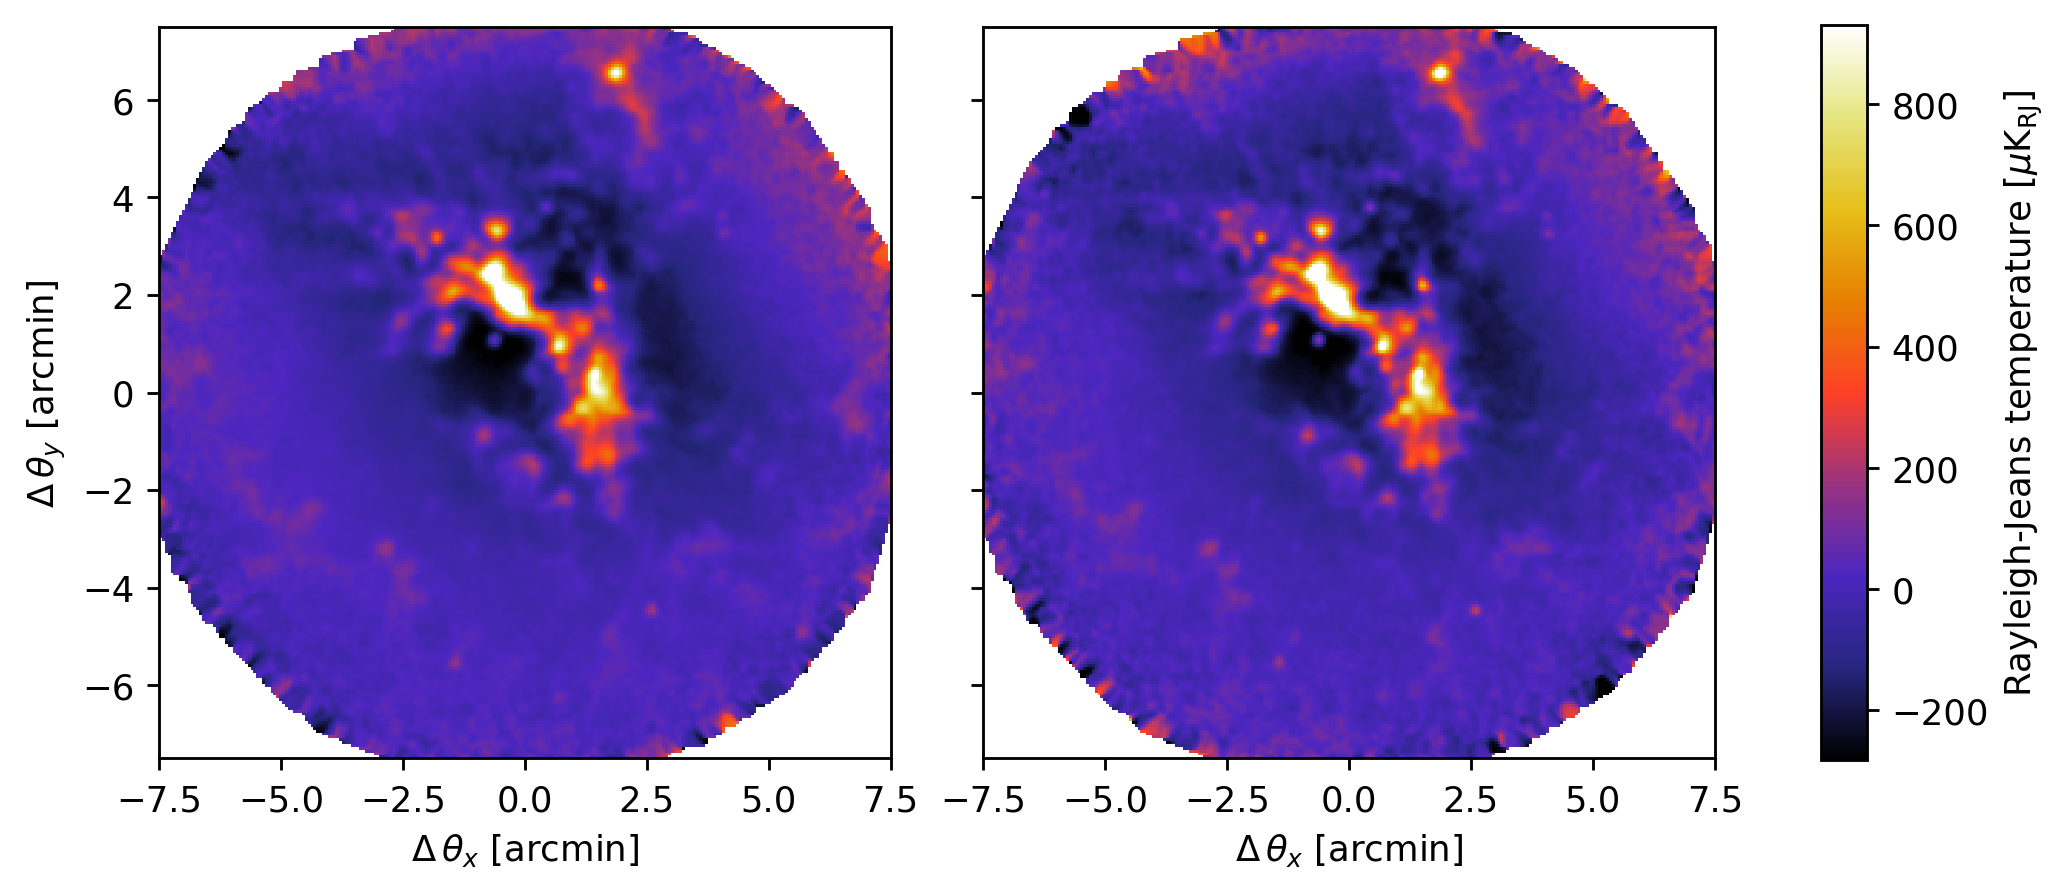

In [8]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=(291.156, -31.23),
    frame="ra_dec",
    width=0.25,
    height=0.25,
    resolution=0.25 / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 30, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
        "median_filter": {"size": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tod)

output_map = mapper.run()

print(output_map)
output_map.plot()